In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('/home/juan/Documents/Github_repos/ParEGO_Last_Step/core/acquisition'))
if module_path not in sys.path:
    sys.path.append(module_path)

from multi_objective import MultiObjective
import numpy as np
import matplotlib.pyplot as plt
from multi_outputGP import multi_outputGP
import GPyOpt
from pygmo import *

warning in stationary: failed to import cython module: falling back to numpy


In [2]:
# Utility function
def true_utility_func(y, parameter):
        #( Ntheta , Ny , Nm)
    parameter = np.atleast_2d(parameter)
    y = np.atleast_2d(y)
    utility = np.sum(y*parameter,axis=-1)
    return utility

def Linear_utility_func(y, parameter):
    #( Ntheta , Ny , Nm)
    parameter = np.atleast_2d(parameter)
    y = np.atleast_2d(y)
    utility = np.sum(y*parameter,axis=-1)
    return utility

def Tchevicheff_utility_func(y, parameter):
    parameter = np.atleast_2d(parameter)
    y = np.atleast_2d(y)
    scaled_vectors = np.abs(parameter * y)
    utility = np.max(scaled_vectors, axis=-1)
    return -utility

def composed_utility_functions(y, u_funcs, weights, parameters):
    y = np.atleast_2d(y)
    weights = np.atleast_2d(weights)
    parameters = np.atleast_2d(parameters)

    y = y[np.newaxis, :,:]
    parameters_partitioned = np.split(parameters, len(u_funcs), axis=1)
    utility_vals = []
    for p in range(len(parameters_partitioned)):
        params = parameters_partitioned[p][:,np.newaxis, :]
        
        if len(weights[:,p].shape)==1:
            w = weights[:,p][:, np.newaxis]
        
        weighted_utility = u_funcs[p](y, params) * w
        utility_vals.append(weighted_utility)
        
    utility = np.sum(utility_vals,axis=0)
    return utility


def prior_sample_generator(d, n_samples=1, seed=None):
    if seed is None:
        samples = np.random.dirichlet(np.ones((d, )), n_samples)
    else:
        random_state = np.random.RandomState(seed)
        samples = random_state.dirichlet(np.ones((d, )), n_samples)
    return samples

In [43]:
class GA:
    # Define objectives
    def __init__(self, f, bounds, n_obj):
        self.f = f
        self.bounds = bounds
        self.n_obj = n_obj
    def fitness(self, x):
        x = np.atleast_2d(x)
        output = self.f(x)
        vect_func_val = []
        for i in range(self.n_obj):
            out = output[:,i]
            vect_func_val.append(out)
        return -np.array(vect_func_val).reshape(-1)

    # Return number of objectives
    def get_nobj(self):
        return self.n_obj

    # Return bounds of decision variables
    def get_bounds(self):
        return self.bounds  # ([0]*1, [2]*1)

    # Return function name
    def get_name(self):
        return "INNER OPTIMISATION PROBLEM"
    
def mean_prediction_model(model):
    def prediction(X):
        X = np.atleast_2d(X)
        mu_x = model.posterior_mean(X)
        mu_x = np.vstack(mu_x).T
       
        return mu_x
    return prediction

def optimistic_prediction_model(model):
    def prediction(X):
        X = np.atleast_2d(X)
        mu_x = model.posterior_mean(X)
        mu_x = np.vstack(mu_x).T
        
        varx = model.posterior_variance(X, noise=False)
        varx = np.vstack(varx).T
        
        optimistic_prediction = mu_x + 1.96* np.sqrt(varx)
        return optimistic_prediction
    return prediction


def pesimistic_prediction_model(model):
    def prediction(X):
        X = np.atleast_2d(X)
        mu_x = model.posterior_mean(X)
        mu_x = np.vstack(mu_x).T
        
        varx = model.posterior_variance(X, noise=False)
        varx = np.vstack(varx).T
        
        optimistic_prediction = mu_x - 1.96* np.sqrt(varx)
        return optimistic_prediction
    return prediction
    
def Generate_Pareto_Front(objective, space,model):
    X_train = model.get_X_values()
    Y_train = objective(X_train)
    
    GP_y_predictions  = mean_prediction_model(model=model)
    GP_optimistic_predictions  = optimistic_prediction_model(model=model)
    GP_pesimistic_predictions  = pesimistic_prediction_model(model=model)
    
    bounds = space.get_continuous_bounds()
    bounds = bounds_format_adapter(bounds)

    udp = GA(f=GP_y_predictions, bounds=bounds, n_obj=Y_train.shape[1])
    pop = population(prob=udp, size=100)
    algo = algorithm(nsga2(gen=100))
    pop = algo.evolve(pop)
    fits, vectors = pop.get_f(), pop.get_x()
    ndf, dl, dc, ndr = fast_non_dominated_sorting(fits)
    result_x = vectors[ndf[0]]
    result_fx_predicted = fits[ndf[0]]
    
    udp = GA(f=GP_optimistic_predictions, bounds=bounds, n_obj=Y_train.shape[1])
    pop = population(prob=udp, size=100)
    algo = algorithm(nsga2(gen=100))
    pop = algo.evolve(pop)
    fits, vectors = pop.get_f(), pop.get_x()
    ndf, dl, dc, ndr = fast_non_dominated_sorting(fits)
    result_x = vectors[ndf[0]]
    result_fx_optimistic = fits[ndf[0]]
    
    udp = GA(f=GP_pesimistic_predictions, bounds=bounds, n_obj=Y_train.shape[1])
    pop = population(prob=udp, size=100)
    algo = algorithm(nsga2(gen=100))
    pop = algo.evolve(pop)
    fits, vectors = pop.get_f(), pop.get_x()
    ndf, dl, dc, ndr = fast_non_dominated_sorting(fits)
    result_x = vectors[ndf[0]]
    result_fx_pesimistic = fits[ndf[0]]
    
    X_plot = np.random.random((1000000, d))
    mu_predicted = GP_y_predictions(X_plot)
    plt.scatter(mu_predicted[:,0], mu_predicted[:,1], color="grey", label="predicted mean surface")
    plt.scatter(-result_fx_optimistic[:,0], -result_fx_optimistic[:,1], color="orange", label="optimistic front")
    plt.scatter(-result_fx_pesimistic[:,0], -result_fx_pesimistic[:,1], color="red", label="pesimistic front")
    plt.scatter(-result_fx_predicted[:,0], -result_fx_predicted[:,1], color="blue", label="mean prediction")
    plt.scatter(Y_train[:,0], Y_train[:,1],label="sampled ys")
    plt.xlabel("$y_{1}$")
    plt.ylabel("$y_{2}$")
    plt.legend()
    plt.show()
    raise
    return result_fx, GP_y_predictions

def bounds_format_adapter(bounds):
    bounds = np.array(bounds)
    bounds_correct_format = []
    for b in range(bounds.shape[1]):
        bounds_correct_format.append(list(bounds[:,b]))
    return bounds_correct_format

In [44]:
# Attributes
d = 6
m = 2

# Attributes
def f(X):
    fX = np.zeros((X.shape[0], m))
    for j in range(m):
        fX[ :,j] += np.square(1 - X[:, j])
        for i in range(d):
            if i != j:
                fX[ :, j] += np.square(X[:, i])
    return -fX

reconstraining parameters GP_regression.Mat32
reconstraining parameters GP_regression.Gaussian_noise.variance


create model
matern kernel
Y [[-0.98019942]
 [-1.87458237]
 [-2.34054084]
 [-2.93444648]
 [-1.62433515]
 [-2.77037169]
 [-2.89553073]
 [-2.26374198]
 [-1.10066565]
 [-1.44942849]
 [-1.92066219]
 [-2.44948522]
 [-2.55942804]
 [-2.44400895]
 [-3.27645597]
 [-2.44491746]
 [-1.10380689]
 [-2.21876872]
 [-2.4939949 ]
 [-3.38509446]
 [-2.0527301 ]
 [-2.28557658]
 [-1.69018655]
 [-0.92314916]
 [-1.79717484]
 [-2.77786669]
 [-2.9447052 ]
 [-1.09800627]
 [-2.03726108]
 [-1.41658858]
 [-1.46774412]
 [-2.26368324]
 [-2.41427075]
 [-3.51013042]
 [-2.97735476]
 [-1.61421055]
 [-2.68171814]
 [-3.52417326]
 [-2.0732303 ]
 [-1.8111423 ]
 [-2.62933328]
 [-3.3306727 ]
 [-3.11434644]
 [-3.21144294]
 [-1.09050224]
 [-2.43856021]
 [-3.16980555]
 [-1.90325503]
 [-2.12438421]
 [-1.58479009]]


reconstraining parameters GP_regression.Mat32
reconstraining parameters GP_regression.Gaussian_noise.variance


self.model 
Name : GP regression
Objective : 0.05178490230184707
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |    priors  
  Mat32.variance           |  7.785940074833368  |      +ve      |  Ga(1, 0.5)
  Mat32.lengthscale        |  6.893820798177418  |      +ve      |  Ga(1, 0.5)
  Gaussian_noise.variance  |              1e-06  |   +ve fixed   |  Ga(1, 0.5)
create model
matern kernel
Y [[-0.37359445]
 [-1.55598133]
 [-0.99321047]
 [-2.81901738]
 [-1.58790012]
 [-2.12485011]
 [-2.59928125]
 [-1.24607131]
 [-1.41615918]
 [-2.32584972]
 [-1.29721907]
 [-2.74729629]
 [-1.22319815]
 [-2.49363718]
 [-2.02453932]
 [-0.77543089]
 [-1.76320696]
 [-3.2761134 ]
 [-1.88114303]
 [-2.0061687 ]
 [-2.0400684 ]
 [-1.70715876]
 [-2.77495241]
 [-1.15598959]
 [-1.67129034]
 [-0.98726259]
 [-2.17284631]
 [-0.67995591]
 [-2.11221713]
 [-1.02781615]
 [-2.30683112]
 [-1.37163005]
 [-2.34004661]
 [-2.

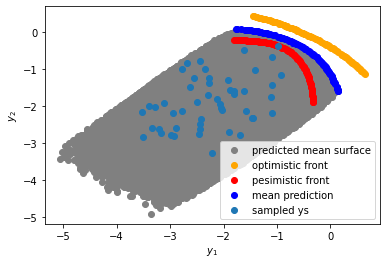

RuntimeError: No active exception to reraise

In [46]:
def generate_pf_dm_samples(Nfronts, true_utility, objective,initial_design= 5, seed=1):
    np.random.seed(seed)
    PF_samples = []
    PF_decisions = []
    true_dm_param = prior_sample_generator(m, n_samples=1, seed=seed)
    for n in range(Nfronts):
        initial_n_samples = initial_design
        X_train = np.random.random((initial_n_samples, d))
        y_train = objective(X_train)
        space = GPyOpt.Design_space(space=[{'name': 'var', 'type': 'continuous', 'domain': (0, 1), 'dimensionality': d}])
        model = multi_outputGP(output_dim=m, 
                               noise_var=[1e-06]*m,
                               exact_feval=[True] * m)
        
        X_inmodel = space.unzip_inputs(X_train)
        Y_inmodel = [np.atleast_2d(y).T for y in y_train.T.tolist()]
        
        model.updateModel(X_inmodel, Y_inmodel)
        result_fx, _ = Generate_Pareto_Front(objective=f, space = space, model=model)
        results_fx = -result_fx
        PF_samples.append(results_fx)
        
        uindex = np.argmax(true_utility_func(y=results_fx, parameter=true_dm_param))
        
        chosen_choice = results_fx[uindex]
        
        PF_decisions.append(chosen_choice)
        
    return PF_samples, PF_decisions

PF_samples, PF_decisions = generate_pf_dm_samples(Nfronts=30, true_utility=true_utility_func, objective=f, initial_design= 50, seed=1)

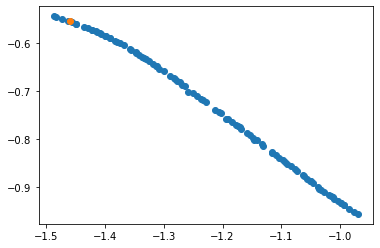

In [197]:
k_sample = 9
plt.scatter(PF_samples[k_sample][:,0],PF_samples[k_sample][:,1]) 
plt.scatter(PF_decisions[k_sample][0],PF_decisions[k_sample][1])

In [266]:
true_dm_param = prior_sample_generator(m, n_samples=1, seed=1)
true_dm_param

array([[0.29751149, 0.70248851]])

In [270]:
np.hstack((np.repeat(true_dm_param,4,axis=0), np.repeat(true_dm_param,4,axis=0)))

array([[0.29751149, 0.70248851, 0.29751149, 0.70248851],
       [0.29751149, 0.70248851, 0.29751149, 0.70248851],
       [0.29751149, 0.70248851, 0.29751149, 0.70248851],
       [0.29751149, 0.70248851, 0.29751149, 0.70248851]])

In [319]:
class Inference_method():
    def __init__(self, u_funcs, d):
        n_ufuncs = len(u_funcs)
        self.m = d
        
    def prior_samples(self, n_samples = 10):
        weights = prior_sample_generator(d=len(u_funcs),n_samples=n_samples)
        Theta = []
        for n_ufuncs in range(len(u_funcs)):
            Theta.append(prior_sample_generator(d = self.m , n_samples=n_samples))
        return weights, np.hstack(Theta)
    
    def Likelihood_sample(self, n_samples, Pareto_front, preferred_points):
        assert len(Pareto_front) == len(preferred_points); "data does not coincide"
        
        w, t = self.prior_samples(n_samples=n_samples)
        
        w = np.vstack((w,np.identity(len(u_funcs))))
        true_info = np.hstack((np.repeat(true_dm_param,len(u_funcs),axis=0), np.repeat(true_dm_param,len(u_funcs),axis=0)))
        t = np.vstack((t,true_info))
        
        compatible_w, compatible_t = w , t
        
        for k in range(len(Pareto_front)):
            plt.scatter(compatible_w[:,0], compatible_w[:,1])
            plt.xlabel("w_{linear}")
            plt.ylabel("w_{tchevicheff}")
            plt.xlim((0,1))
            plt.ylim((0,1))
            plt.show()
            
            plt.title("Linear parameters")
            plt.scatter(compatible_t[:, :2][:,0],compatible_t[:, :2][:,1])
            plt.xlabel("theta linear 1")
            plt.ylabel("theta linear 2")
            plt.show()
            
            plt.title("Tchevicheff parameters")
            plt.scatter(compatible_t[:, 2:][:,0],compatible_t[:, 2:][:,1])
            plt.xlabel("theta linear 1")
            plt.ylabel("theta linear 2")
            plt.show()
       
            utility_vals = composed_utility_functions(y=Pareto_front[k], u_funcs=u_funcs, weights=compatible_w, parameters = compatible_t)
            pf_idxlist = np.array(range(Pareto_front[k].shape[0]))
            pidx = np.all(Pareto_front[k] == preferred_points[k],axis=1)
            optimal_idxlist_val = pf_idxlist[pidx]
            if len(optimal_idxlist_val)>1:
                optimal_idxlist_val = optimal_idxlist_val[0]
            comparison = optimal_idxlist_val == np.argmax(utility_vals,axis=1)
            compatible_w, compatible_t = compatible_w[comparison], compatible_t[comparison]
            if len(compatible_w)==0:
                return [], []
        return compatible_w, compatible_t 

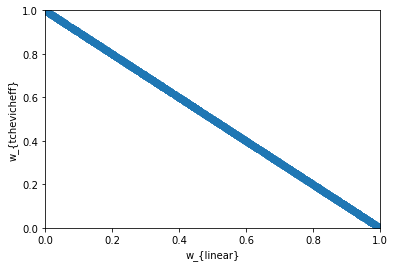

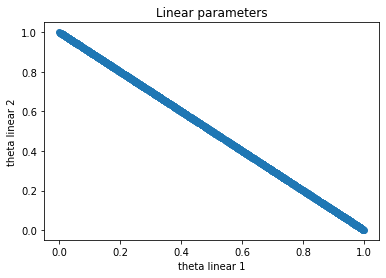

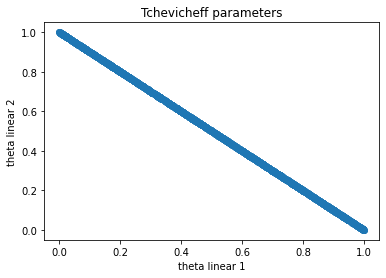

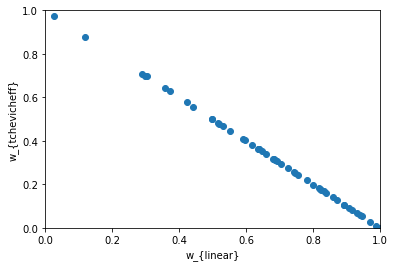

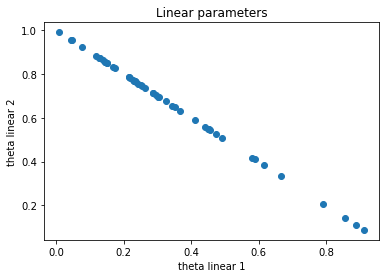

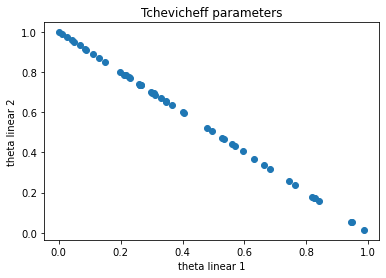

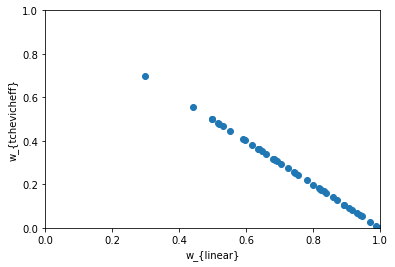

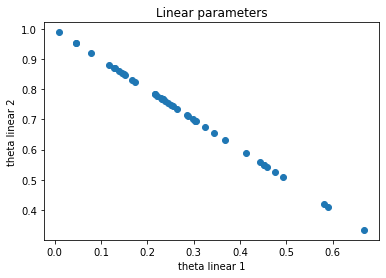

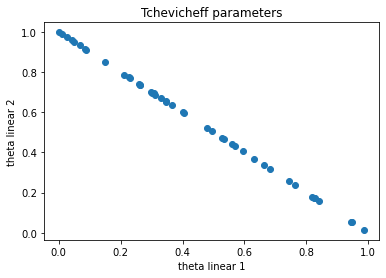

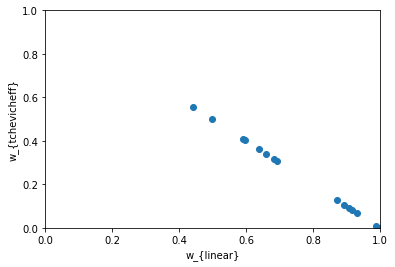

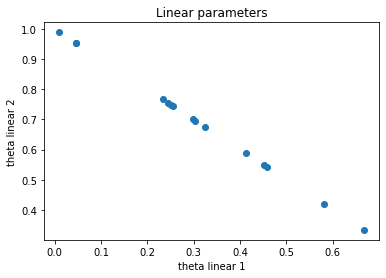

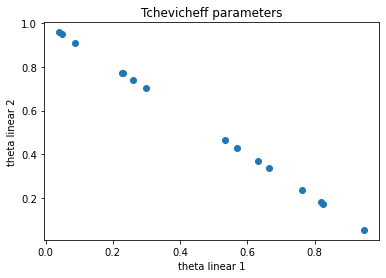

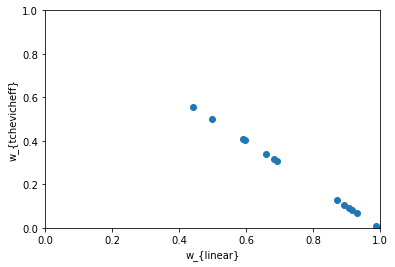

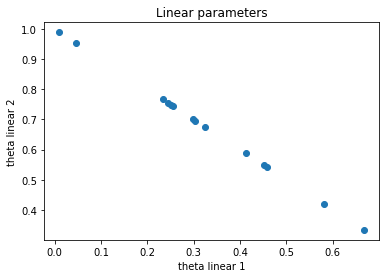

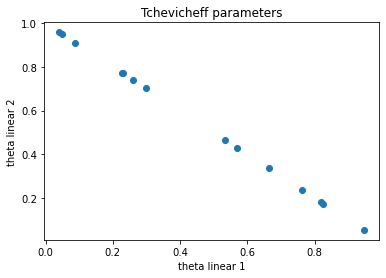

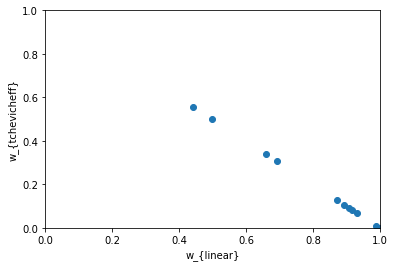

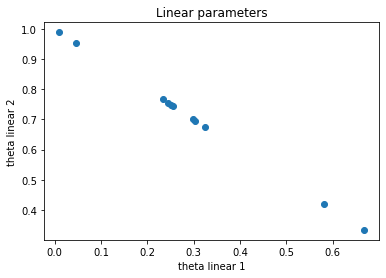

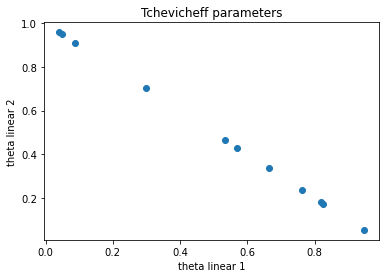

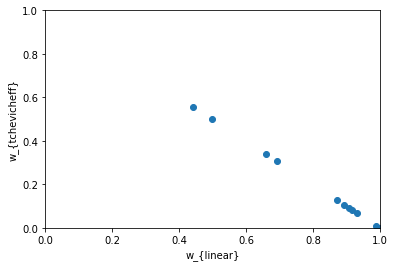

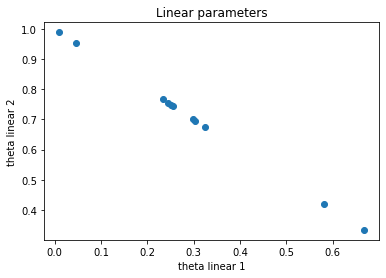

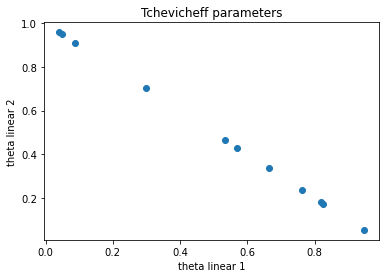

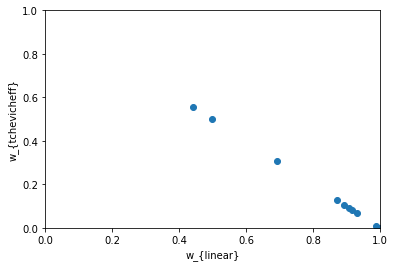

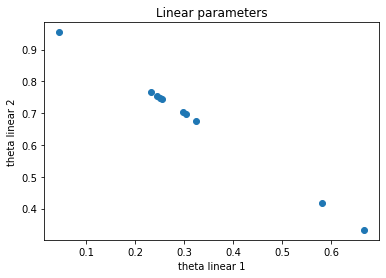

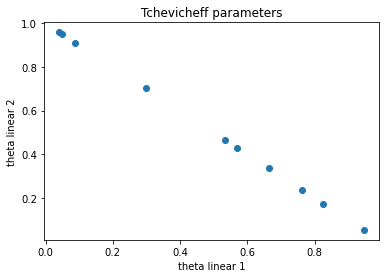

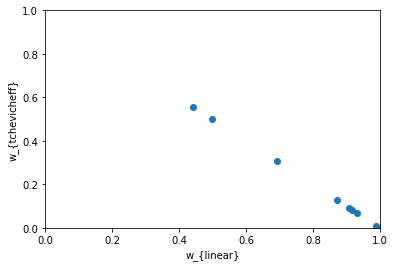

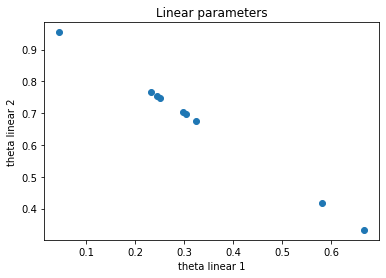

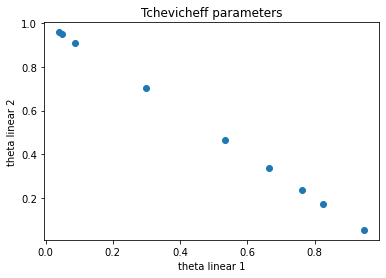

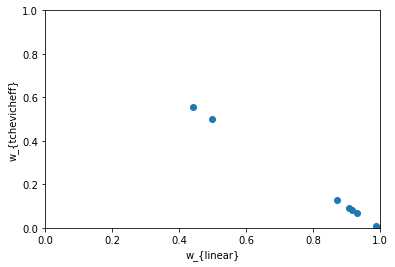

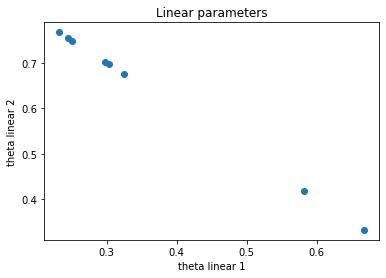

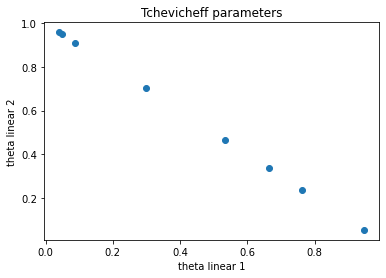

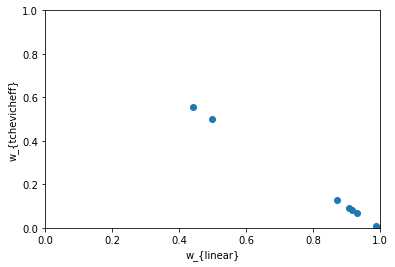

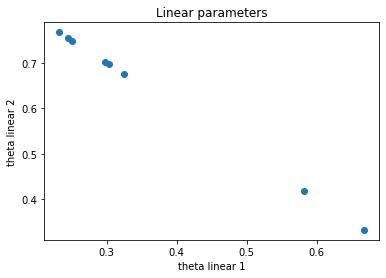

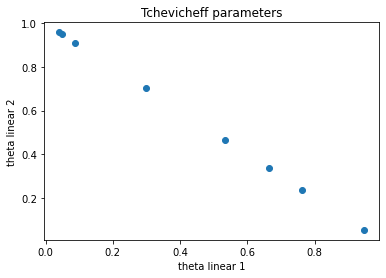

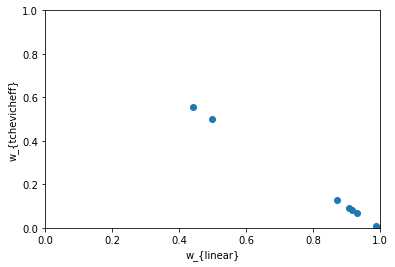

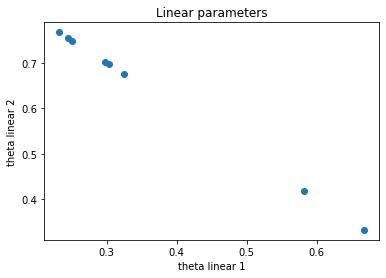

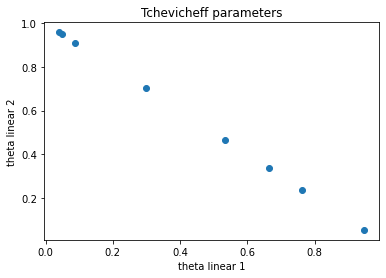

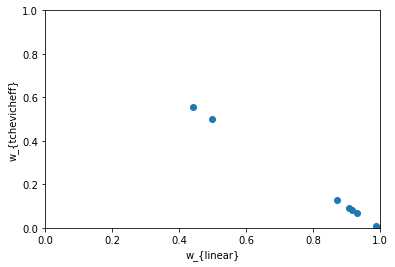

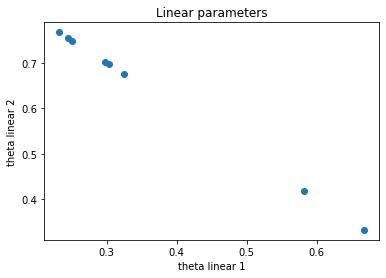

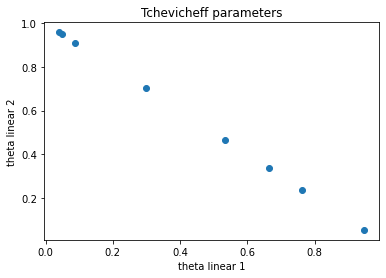

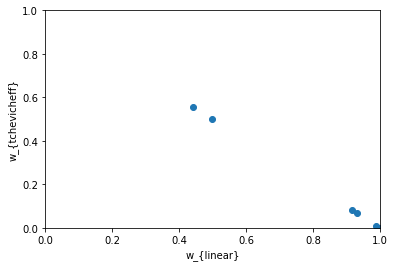

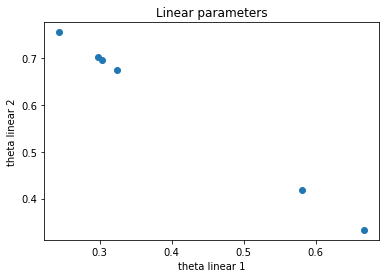

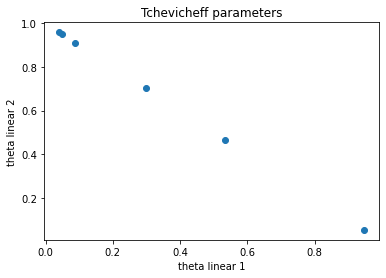

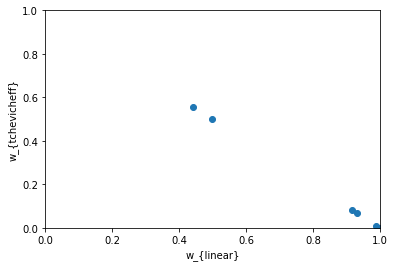

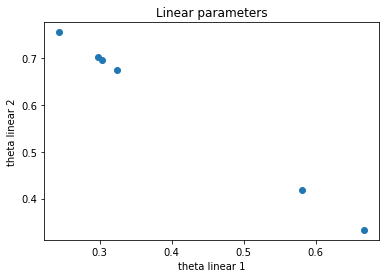

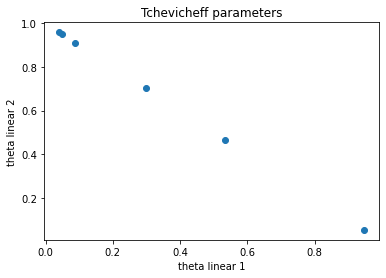

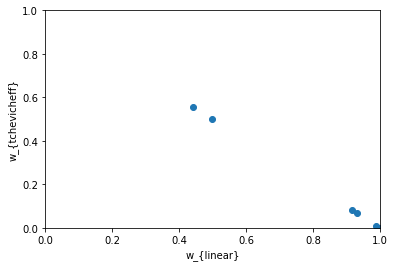

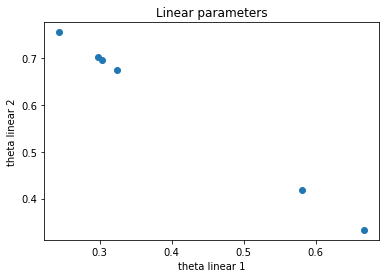

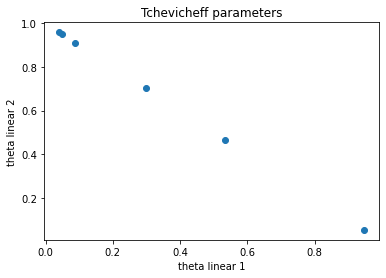

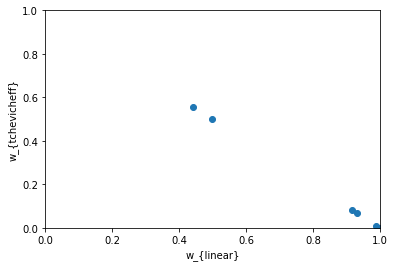

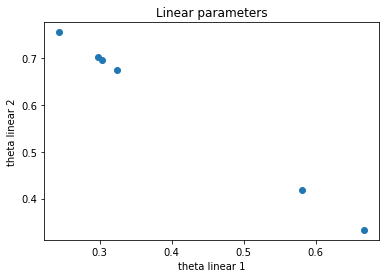

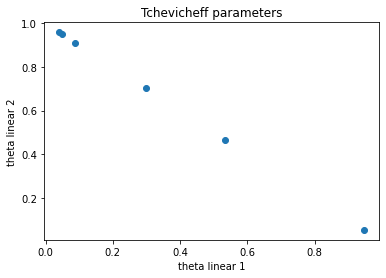

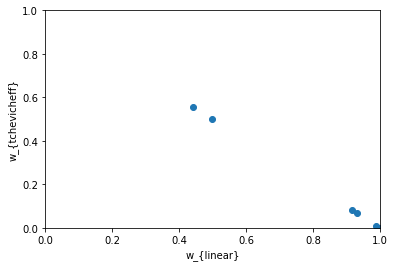

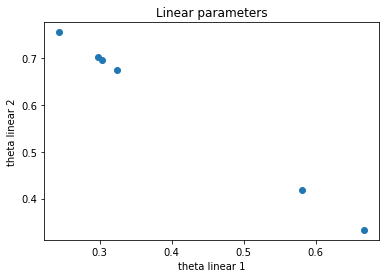

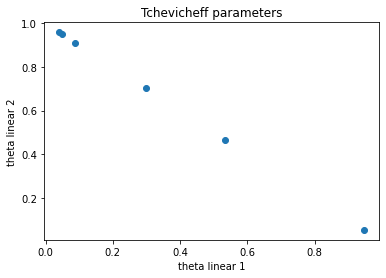

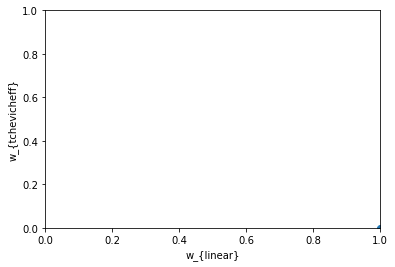

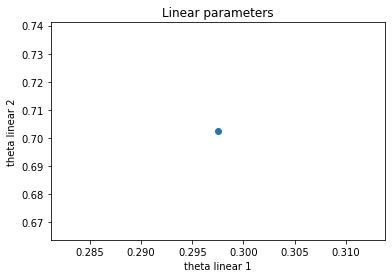

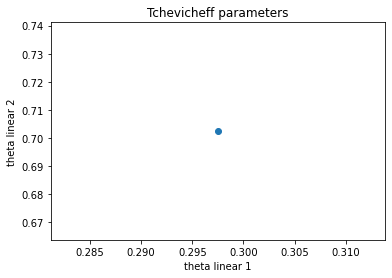

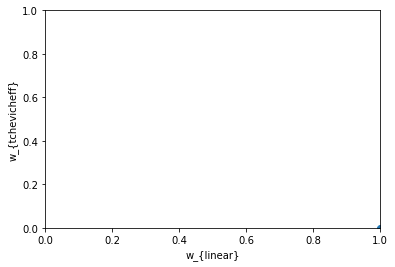

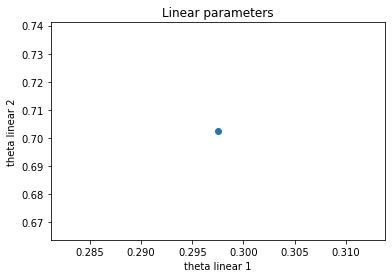

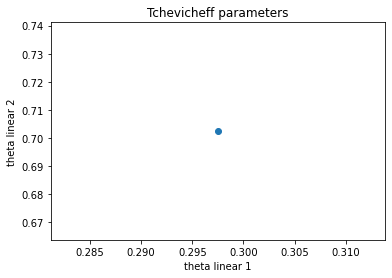

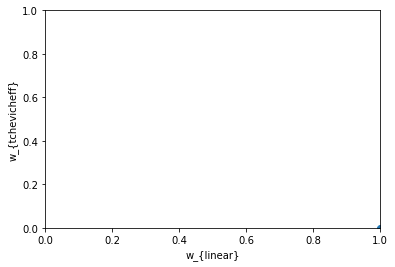

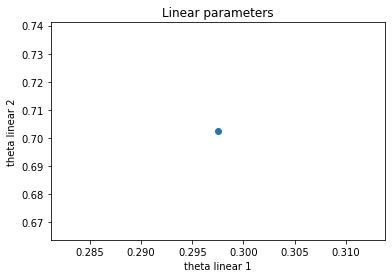

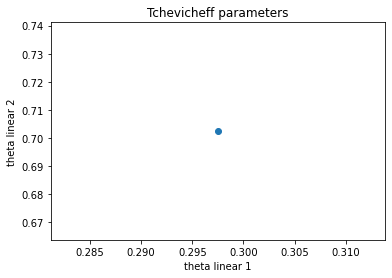

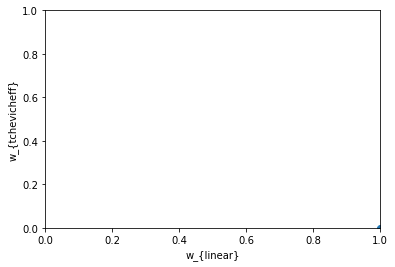

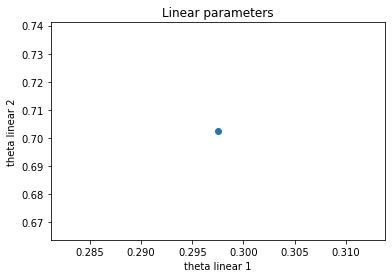

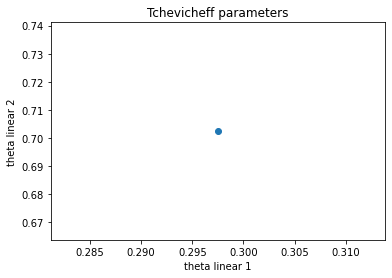

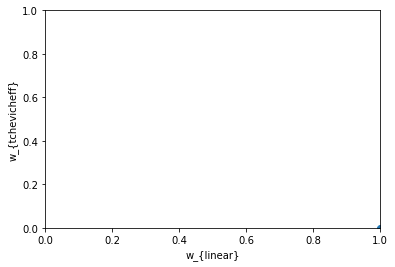

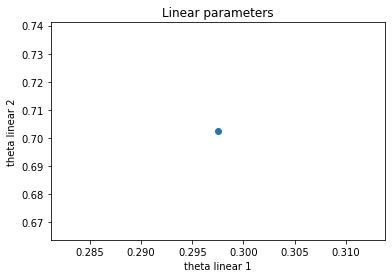

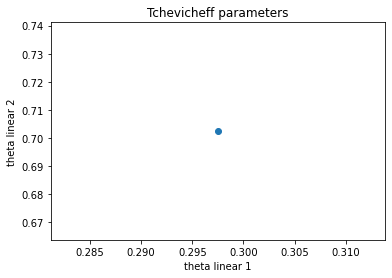

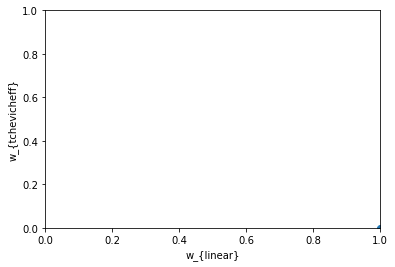

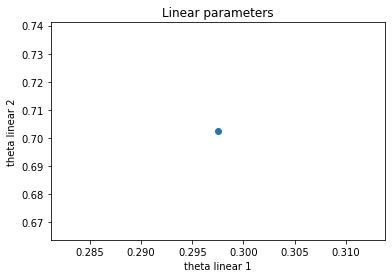

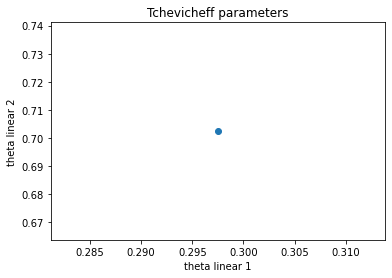

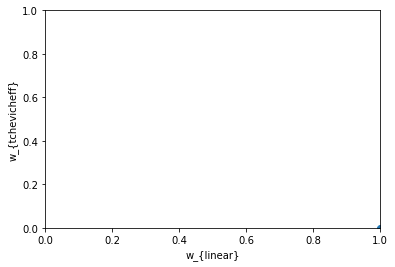

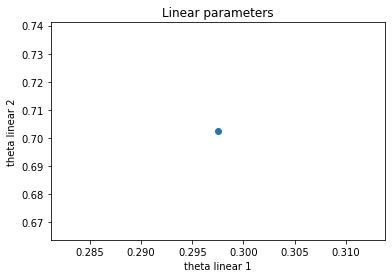

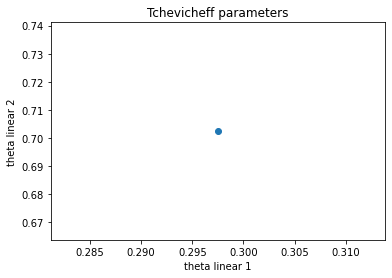

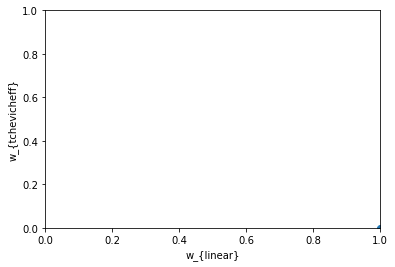

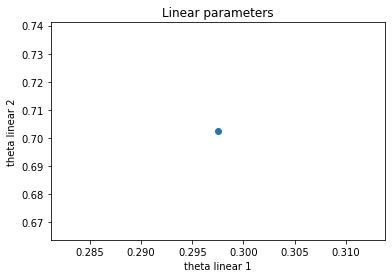

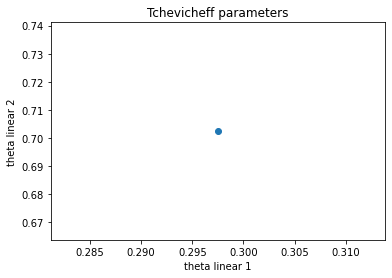

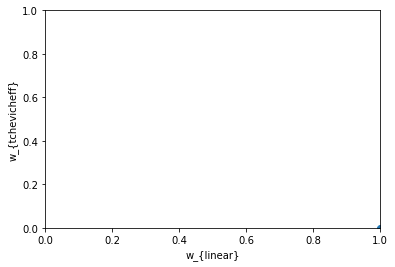

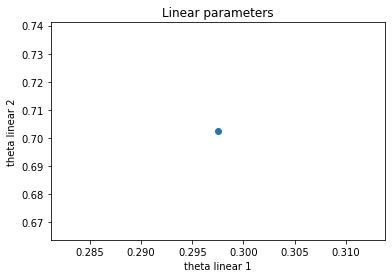

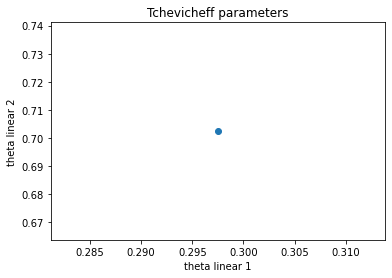

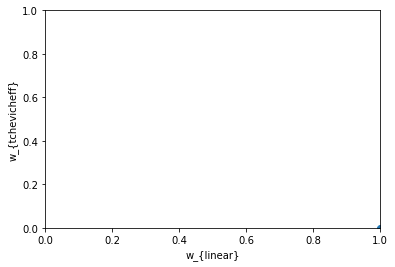

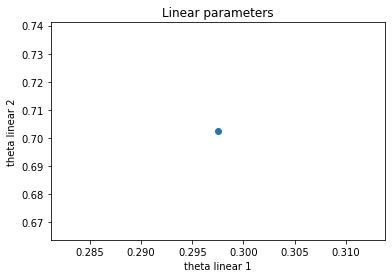

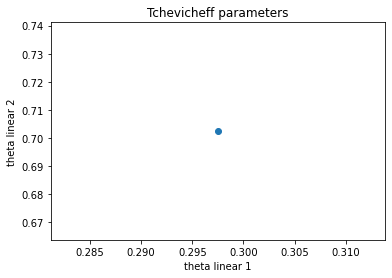

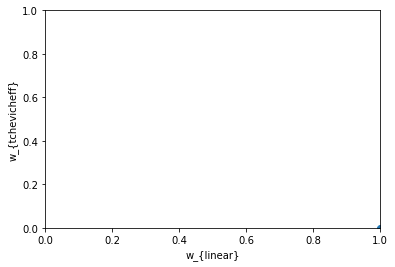

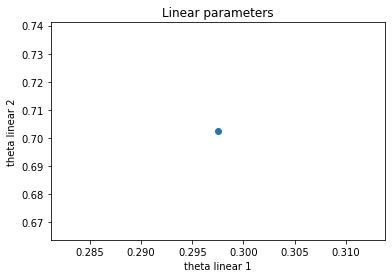

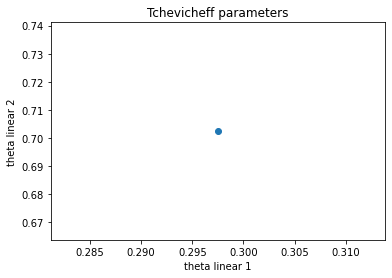

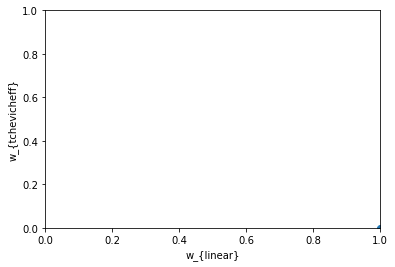

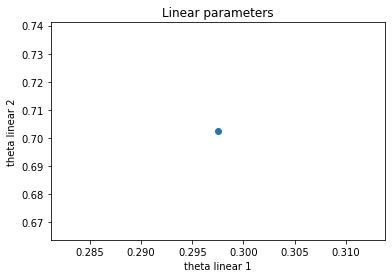

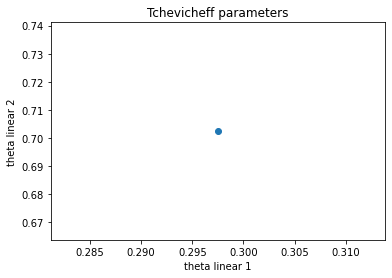

In [320]:
u_funcs = [Linear_utility_func, Tchevicheff_utility_func]

BayesInference = Inference_method(u_funcs, 2)

w_samples, t_samples = BayesInference.Likelihood_sample(2000, Pareto_front = PF_samples,preferred_points= PF_decisions)

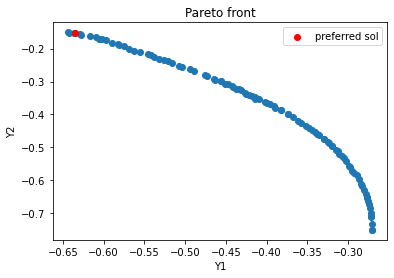

In [329]:
k_sample = 4
plt.scatter(PF_samples[k_sample][:,0], PF_samples[k_sample][:,1])
plt.scatter(PF_decisions[k_sample][0], PF_decisions[k_sample][1],color="red", label="preferred sol")
plt.legend()
plt.title("Pareto front")
plt.ylabel("Y2")
plt.xlabel("Y1")
plt.show()
# k_sample = 6
# utility_vals = composed_utility_functions(y=PF_samples[k_sample], u_funcs=u_funcs, weights=w_samples[k_sample], parameters = t_samples[k_sample])
# plt.scatter(PF_samples[0][np.argmax(utility_vals),0], PF_samples[0][np.argmax(utility_vals),1], color="yellow")

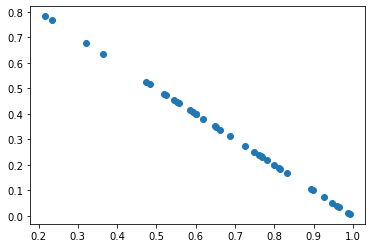

In [249]:
plt.scatter(w_samples[:,0], w_samples[:,1])

In [263]:
w = np.identity(5)

In [264]:
w

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])